In [ ]:
!python3 -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 724.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 23.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import re
import time
import math
import random
import ast
import numpy as np
import pandas as pd
import spacy
import ru_core_news_sm

import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from typing import Tuple
from tqdm import tqdm

import torch.optim as optim
from torch import Tensor
import torch.optim as optim
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import vocab
import matplotlib.pyplot as plt

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

# from seq2seq_attention.visualize_attention import get_attention_frames

from tqdm import notebook
pd.set_option('display.max_colwidth', 200)

import warnings
warnings.filterwarnings('ignore')

from collections import Counter, OrderedDict
from sklearn.model_selection import train_test_split
from torchtext.vocab import vocab
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from torchtext.vocab import vocab
from torchtext.data.utils import get_tokenizer
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


In [ ]:
# df = pd.read_csv("/content/gdrive/MyDrive/rus.txt", sep="\t", names=["English", "Russian", "lic"])
#loading already tokenized data
df = pd.read_csv("/content/gdrive/MyDrive/tokenizer_data.csv")

In [ ]:
df.head(50)

,Unnamed: 0,English,Russian
0,0,['go'],['марш']
1,1,['go'],['иди']
2,2,['go'],['идите']
3,3,['hi'],['здравствуйте']
4,4,['hi'],['привет']
5,5,['hi'],['хай']
6,6,['hi'],['здрасте']
7,7,['hi'],"['здоро', 'во']"
8,8,['hi'],['приветик']
9,9,['run'],['беги']


In [ ]:
# df.drop("lic", axis=1, inplace=True)

In [ ]:
#CFG
# max_eng_len = 40
# max_rus_len = 40
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# def clean_text(text):
#     text = text.lower()
#     pattern = re.compile('\W')
#     text = re.sub(pattern,' ',text).strip()
#     return text

In [ ]:
# df.English = df.English.apply(clean_text)
# df.Russian = df.Russian.apply(clean_text)

In [ ]:
# Load the Russian model
rus_tokenizer = spacy.load("ru_core_news_sm")

# Load the English model
eng_tokenizer = spacy.load("en_core_web_sm")

In [ ]:
def tokenize_russian(text):
  return [tok.text for tok in rus_tokenizer.tokenizer(text)]

# Tokenizes English text from a string into a list of tokens
def tokenize_en(text):
  return [tok.text for tok in eng_tokenizer.tokenizer(text)]

In [ ]:
def build_vocab(series, tokenizer):
    counter = Counter()
    for text in series:
        counter.update(tokenizer(text))
    # Sort tokens by frequency and extract only the tokens, not their frequencies
    sorted_tokens = sorted(counter.keys(), key=lambda token: -counter[token])
    # Create a Vocab object with these sorted tokens, and specify special tokens
    return vocab(OrderedDict((token, 1) for token in sorted_tokens), specials=['<unk>', '<pad>', '<bos>', '<eos>'])

In [ ]:
def spacy_tokenizer(text, tokenizer):
 return [tok.text for tok in tokenizer(text)]

In [ ]:
# df.Russian = df.Russian.apply(lambda text: spacy_tokenizer(text, rus_tokenizer))
# df.English = df.English.apply(lambda text: spacy_tokenizer(text, eng_tokenizer))

In [ ]:
# df.to_csv("/content/gdrive/MyDrive/tokenizer_data.csv")

In [ ]:
df['English'] = df['English'].apply(ast.literal_eval)
df['Russian'] = df['Russian'].apply(ast.literal_eval)

In [ ]:
df.English[0]

['go']

In [ ]:
ru_vocab = build_vocab(df.Russian, lambda tokens: tokens) # Since df.Russian is already tokenized
en_vocab = build_vocab(df.English, lambda tokens: tokens) # Since df.English is already tokenized

In [ ]:
len(ru_vocab)

60048

In [ ]:
def data_process(df, ru_vocab, en_vocab):
    data = []
    for _, row in df.iterrows():
        eng_tokens = row['English']
        rus_tokens = row['Russian']

        # Convert tokens to tensor indices using vocabularies
        ru_tensor_ = torch.tensor([ru_vocab[token] if token in ru_vocab else ru_vocab['<unk>'] for token in rus_tokens], dtype=torch.long)
        en_tensor_ = torch.tensor([en_vocab[token] if token in en_vocab else en_vocab['<unk>'] for token in eng_tokens], dtype=torch.long)
        data.append((ru_tensor_, en_tensor_))
    return data

In [ ]:
# train_df = df.loc[:int(len(df)*0.9)]
# val_df = df.loc[int(len(df)*0.9):]
train_df, val_df = train_test_split(df, test_size = 0.2, shuffle = True)
train_data = data_process(train_df, ru_vocab, en_vocab)
val_data = data_process(val_df, ru_vocab, en_vocab)

In [ ]:
train_df.head()

,Unnamed: 0,English,Russian
395047,395047,"[you, don, t, need, to, go, in, such, a, hurry]","[вам, не, нужно, так, поспешно, идти]"
34500,34500,"[i, never, knew, tom]","[я, никогда, не, был, знаком, с, томом]"
247292,247292,"[are, you, sure, you, re, not, busy]","[ты, уверена, , что, не, занята]"
269531,269531,"[he, had, to, work, even, on, sunday]","[ему, пришлось, работать, даже, в, воскресенье]"
353024,353024,"[tom, leaves, his, tv, on, all, day, long]","[том, целый, день, не, выключает, телевизор]"


In [ ]:
train_data[:5]

[(tensor([   29,     6,    62,    34, 11069,   157]),
  tensor([  5,  18,   8,  70,   7,  44,  19, 400,  11, 493])),
 (tensor([  5,  66,   6,  31, 653,  16,  58]), tensor([  4,  85, 136,   6])),
 (tensor([ 11, 485,   4,   8,   6, 827]),
  tensor([ 33,   5, 127,   5,  42,  41, 243])),
 (tensor([  98,  367,  288,  215,   10, 1269]),
  tensor([ 21,  76,   7, 126, 241,  45, 999])),
 (tensor([    7,  1782,   107,     6, 33717,   380]),
  tensor([   6, 1084,   49,  396,   45,   64,  144,  156]))]

In [ ]:
BATCH_SIZE = 128
PAD_IDX = en_vocab['<pad>']
BOS_IDX = en_vocab['<bos>']
EOS_IDX = en_vocab['<eos>']

In [ ]:
def generate_batch(data_batch):
  ru_batch, en_batch = [], []
  for (ru_item, en_item) in data_batch:
    ru_batch.append(torch.cat([torch.tensor([BOS_IDX]), ru_item, torch.tensor([EOS_IDX])], dim=0))
    en_batch.append(torch.cat([torch.tensor([BOS_IDX]), en_item, torch.tensor([EOS_IDX])], dim=0))
  ru_batch = pad_sequence(ru_batch, padding_value=PAD_IDX)
  en_batch = pad_sequence(en_batch, padding_value=PAD_IDX)
  return ru_batch, en_batch # (T, batch_size) output

In [ ]:
train_iter = DataLoader(train_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(val_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)

In [ ]:
class Encoder(nn.Module):

  def __init__(self, input_dim, hidden_size, embedding_size, num_layers=2, dropout=0.3):

    super(Encoder, self).__init__()

    # Basic network params
    self.hidden_size = hidden_size
    self.embedding_size = embedding_size
    self.num_layers = num_layers
    self.dropout = dropout

    # Embedding layer that will be shared with Decoder
    self.embedding = nn.Embedding(input_dim, embedding_size)
    # GRU layer
    self.gru = nn.GRU(embedding_size, hidden_size,
                      num_layers=num_layers,
                      dropout=dropout)

  def forward(self, input_sequence):

    # Convert input_sequence to word embeddings
    embedded = self.embedding(input_sequence)

    outputs, hidden = self.gru(embedded)

    # The ouput of a GRU has shape -> (seq_len, batch, hidden_size)
    return outputs, hidden

In [ ]:
class Attention(nn.Module):
  def __init__(self, hidden_size):
    super(Attention, self).__init__()
    self.hidden_size = hidden_size


  def dot_score(self, hidden_state, encoder_states):
    return torch.sum(hidden_state * encoder_states, dim=2)


  def forward(self, hidden, encoder_outputs, mask):
    # print(f"mask shape = {mask.shape}")
    attn_scores = self.dot_score(hidden, encoder_outputs)

    # Transpose max_length and batch_size dimensions
    attn_scores = attn_scores.t()

    # Apply mask so network does not attend <pad> tokens
    attn_scores = attn_scores.masked_fill(mask == 0, -1e5)

    # Return softmax over attention scores
    return F.softmax(attn_scores, dim=1).unsqueeze(1)

In [ ]:
class Decoder(nn.Module):
  def __init__(self, embedding_size, hidden_size, output_size, n_layers=2, dropout=0.3):

    super(Decoder, self).__init__()

    # Basic network params
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.n_layers = n_layers
    self.dropout = dropout
    self.embedding = nn.Embedding(output_size, embedding_size)

    self.gru = nn.GRU(embedding_size, hidden_size, n_layers,
                      dropout=dropout)

    self.concat = nn.Linear(hidden_size * 2, hidden_size)
    self.out = nn.Linear(hidden_size, output_size)
    self.attn = Attention(hidden_size)

  def forward(self, current_token, hidden_state, encoder_outputs, mask):

    # convert current_token to word_embedding
    embedded = self.embedding(current_token)

    # Pass through GRU
    gru_output, hidden_state = self.gru(embedded, hidden_state)
    # print(f"decoder gru output shape = {gru_output.shape}")
    # print(f"encoder output shape for attention = {encoder_outputs.shape}")

    # Calculate attention weights
    attention_weights = self.attn(gru_output, encoder_outputs, mask)

    # Calculate context vector (weigthed average)
    context = attention_weights.bmm(encoder_outputs.transpose(0, 1))

    # Concatenate  context vector and GRU output
    gru_output = gru_output.squeeze(0)
    context = context.squeeze(1)
    concat_input = torch.cat((gru_output, context), 1)
    concat_output = torch.tanh(self.concat(concat_input))

    # Pass concat_output to final output layer
    output = self.out(concat_output)

    # Return output and final hidden state
    return output, hidden_state, attention_weights

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder: nn.Module, decoder: nn.Module, device: torch.device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def create_mask(self, input_sequence):
      return (input_sequence != PAD_IDX).permute(1, 0)

    def forward(self, src, trg=None, teacher_forcing_ratio=0.5):
        batch_size = src.shape[1]
        encoder_outputs, hidden = self.encoder(src)

        if trg is None:
            max_len = 50  # Define max_len for inference if trg is not provided
            sos_token_index = BOS_IDX
            trg = torch.full((max_len, batch_size), sos_token_index, dtype=torch.long, device=self.device)
        else:
            max_len = trg.shape[0]  # Use provided trg to determine sequence length

        trg_vocab_size = self.decoder.output_size
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size, device=self.device)
        attentions = torch.zeros(max_len, batch_size, src.shape[0], device=self.device)

        # First input to the decoder is the <sos> token
        input = trg[0, :]
        mask = self.create_mask(src)

        for t in range(1, max_len):
            input = input.unsqueeze(0)
            output, hidden, attn = self.decoder(input, hidden, encoder_outputs, mask)
            # print(output.shape)
            # print(hidden.shape)
            # print(attn.shape)
            outputs[t] = output
            attentions[t] = attn.squeeze(1)
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if (teacher_force and t < trg.shape[0]) else top1

        return outputs, attentions

In [ ]:
INPUT_DIM = len(ru_vocab)
OUTPUT_DIM = len(en_vocab)

ENC_EMB_DIM = 64
DEC_EMB_DIM = 64
ENC_HID_DIM = 128
DEC_HID_DIM = 128
ATTN_DIM = 64
ENC_DROPOUT = 0.3
DEC_DROPOUT = 0.3
NUM_LAYERS = 2

enc = Encoder(INPUT_DIM, ENC_HID_DIM, ENC_EMB_DIM, NUM_LAYERS, ENC_DROPOUT)

# attn = Attention(ENC_HID_DIM)

dec = Decoder(DEC_EMB_DIM, DEC_HID_DIM, OUTPUT_DIM, NUM_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)


def init_weights(m: nn.Module):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)


model.apply(init_weights)

optimizer = optim.Adam(model.parameters())


def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 7,615,851 trainable parameters


In [ ]:
PAD_IDX = en_vocab.get_stoi()['<pad>']

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [ ]:
def indices_to_words(indices, vocab):
    # Convert indices to words using TorchText vocab
    words = []
    for idx in indices:
        if(idx != PAD_IDX and idx != BOS_IDX and idx != EOS_IDX):
          word = vocab.get_itos()[idx]
          words.append(word)
    return words

def calculate_bleu(data_loader, model, device, vocab):
    model.eval()
    targets = []
    predictions = []

    with torch.no_grad():
        for src, trg in tqdm(data_loader):
            src, trg = src.to(device), trg.to(device)
            output, attn = model(src, trg, 0)  # Assume model returns logits
            output = output.argmax(-1)
            # Transpose output to match (batch_size, T) format
            output = output.transpose(0, 1)
            trg = trg.transpose(0, 1)
            predictions.extend(output.cpu().numpy().tolist())
            targets.extend(trg.cpu().numpy().tolist())

    # Convert indices to words
    targets = [indices_to_words(t, vocab) for t in targets]
    predictions = [indices_to_words(p, vocab) for p in predictions]

    # Calculate BLEU score
    bleu_score = corpus_bleu([[t] for t in targets], predictions)
    return bleu_score

In [ ]:
# del model
# import gc
# gc.collect()
# torch.cuda.empty_cache()

In [ ]:
def train(model: nn.Module,
          iterator: torch.utils.data.DataLoader,
          optimizer: optim.Optimizer,
          criterion: nn.Module,
          clip: float):

    model.train()

    epoch_loss = 0
    for _, (src, trg) in tqdm(enumerate(iterator)):
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()

        output, attn = model(src, trg)

        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)


def evaluate(model: nn.Module,
             iterator: torch.utils.data.DataLoader,
             criterion: nn.Module):

    model.eval()

    epoch_loss = 0
    example_outputs = []

    with torch.no_grad():

        for _, (src, trg) in tqdm(enumerate(iterator)):
            src, trg = src.to(device), trg.to(device)

            output, attn = model(src, trg, 0) #turn off teacher forcing

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()

            # Print example outputs and their corresponding targets
    for pred, target in example_outputs:
        print("Predicted:", pred)
        print("Target:", target)

    return epoch_loss / len(iterator)


def epoch_time(start_time: int,
               end_time: int):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


N_EPOCHS = 20
CLIP = 1

best_valid_loss = float('inf')

train_losses = []
val_losses = []
best_loss = 100000

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iter, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iter, criterion)
    # valid_bleu = calculate_bleu(valid_iter, model, device, ru_vocab)  # Make sure device is defined

    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model, "/content/gdrive/MyDrive/Russian_English_model_2layer_GRU.pt")

    train_losses.append(train_loss)
    val_losses.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    # print(f'\t Val. BLEU: {valid_bleu:.2f}')

3101it [04:06, 12.59it/s]
776it [00:20, 38.71it/s]


Epoch: 01 | Time: 4m 26s
	Train Loss: 5.587 | Train PPL: 266.881
	 Val. Loss: 5.557 |  Val. PPL: 259.113


3101it [04:03, 12.74it/s]
776it [00:20, 38.44it/s]


Epoch: 02 | Time: 4m 23s
	Train Loss: 5.017 | Train PPL: 150.945
	 Val. Loss: 4.290 |  Val. PPL:  72.940


3101it [04:03, 12.74it/s]
776it [00:20, 37.72it/s]


Epoch: 03 | Time: 4m 24s
	Train Loss: 3.377 | Train PPL:  29.291
	 Val. Loss: 3.264 |  Val. PPL:  26.142


3101it [04:05, 12.66it/s]
776it [00:20, 38.29it/s]


Epoch: 04 | Time: 4m 25s
	Train Loss: 2.492 | Train PPL:  12.083
	 Val. Loss: 2.695 |  Val. PPL:  14.800


3101it [04:06, 12.58it/s]
776it [00:19, 38.96it/s]


Epoch: 05 | Time: 4m 26s
	Train Loss: 2.023 | Train PPL:   7.559
	 Val. Loss: 2.461 |  Val. PPL:  11.722


3101it [04:04, 12.71it/s]
776it [00:19, 39.33it/s]


Epoch: 06 | Time: 4m 23s
	Train Loss: 1.761 | Train PPL:   5.821
	 Val. Loss: 2.329 |  Val. PPL:  10.271


3101it [04:03, 12.73it/s]
776it [00:19, 38.90it/s]


Epoch: 07 | Time: 4m 23s
	Train Loss: 1.591 | Train PPL:   4.908
	 Val. Loss: 2.250 |  Val. PPL:   9.492


3101it [04:01, 12.84it/s]
776it [00:19, 39.95it/s]


Epoch: 08 | Time: 4m 21s
	Train Loss: 1.462 | Train PPL:   4.316
	 Val. Loss: 2.154 |  Val. PPL:   8.617


3101it [04:02, 12.81it/s]
776it [00:19, 39.90it/s]


Epoch: 09 | Time: 4m 21s
	Train Loss: 1.371 | Train PPL:   3.941
	 Val. Loss: 2.093 |  Val. PPL:   8.106


3101it [04:01, 12.84it/s]
776it [00:19, 39.88it/s]


Epoch: 10 | Time: 4m 21s
	Train Loss: 1.294 | Train PPL:   3.648
	 Val. Loss: 2.055 |  Val. PPL:   7.804


3101it [04:01, 12.84it/s]
776it [00:19, 38.84it/s]


Epoch: 11 | Time: 4m 21s
	Train Loss: 1.231 | Train PPL:   3.426
	 Val. Loss: 2.044 |  Val. PPL:   7.724


3101it [04:02, 12.81it/s]
776it [00:19, 39.76it/s]


Epoch: 12 | Time: 4m 21s
	Train Loss: 1.177 | Train PPL:   3.243
	 Val. Loss: 2.021 |  Val. PPL:   7.548


3101it [04:01, 12.85it/s]
776it [00:19, 40.05it/s]


Epoch: 13 | Time: 4m 20s
	Train Loss: 1.129 | Train PPL:   3.093
	 Val. Loss: 2.025 |  Val. PPL:   7.573


3101it [04:01, 12.86it/s]
776it [00:19, 39.57it/s]


Epoch: 14 | Time: 4m 20s
	Train Loss: 1.098 | Train PPL:   2.999
	 Val. Loss: 2.011 |  Val. PPL:   7.473


3101it [04:02, 12.80it/s]
776it [00:19, 39.80it/s]


Epoch: 15 | Time: 4m 21s
	Train Loss: 1.063 | Train PPL:   2.895
	 Val. Loss: 1.965 |  Val. PPL:   7.132


3101it [04:01, 12.85it/s]
776it [00:19, 39.90it/s]


Epoch: 16 | Time: 4m 20s
	Train Loss: 1.034 | Train PPL:   2.811
	 Val. Loss: 1.958 |  Val. PPL:   7.087


3101it [04:02, 12.80it/s]
776it [00:19, 39.94it/s]


Epoch: 17 | Time: 4m 21s
	Train Loss: 1.003 | Train PPL:   2.726
	 Val. Loss: 1.974 |  Val. PPL:   7.200


3101it [04:02, 12.80it/s]
776it [00:19, 39.94it/s]


Epoch: 18 | Time: 4m 21s
	Train Loss: 0.979 | Train PPL:   2.662
	 Val. Loss: 1.961 |  Val. PPL:   7.104


3101it [04:02, 12.81it/s]
776it [00:19, 39.60it/s]


Epoch: 19 | Time: 4m 21s
	Train Loss: 0.956 | Train PPL:   2.602
	 Val. Loss: 1.955 |  Val. PPL:   7.067


3101it [04:01, 12.83it/s]
776it [00:19, 39.66it/s]

Epoch: 20 | Time: 4m 21s
	Train Loss: 0.942 | Train PPL:   2.566
	 Val. Loss: 1.940 |  Val. PPL:   6.960


Text(0, 0.5, 'loss')

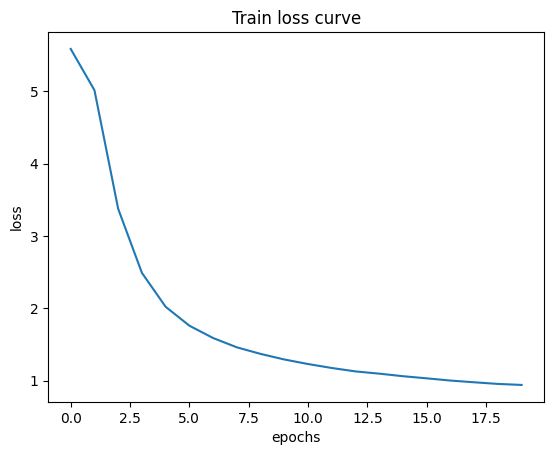

In [ ]:
eps = [i for i in range(N_EPOCHS)]
plt.plot(eps, train_losses)
plt.title(f"Train loss curve")
plt.xlabel("epochs")
plt.ylabel("loss")

In [ ]:
#russian to english translation and attention map
def get_translation_and_attention_frame(sentence, model, rus_tokenizer, eng_vocab, russian_vocab):
  model.eval()
  tokenized_sen = [tok.text for tok in rus_tokenizer.tokenizer(sentence)]
  ru_tensor_ = torch.tensor([russian_vocab[token] if token in russian_vocab else russian_vocab['<unk>'] for token in tokenized_sen], dtype=torch.long)
  input = torch.cat([torch.tensor([BOS_IDX]), ru_tensor_, torch.tensor([EOS_IDX])], dim=0).to(device)

  input = input.unsqueeze(-1)
  output, attn = model(input)
  translation_tensor = torch.argmax(output.squeeze(1), -1)
  translation = [eng_vocab.get_itos()[t] for t in translation_tensor]

  translation = translation[1:]
  attn = attn.squeeze(1)[1:, :]
  first_eos_token = 0
  for c, i in enumerate(translation):
    if(i == "<eos>"):
      first_eos_token = c
      break
  translation = translation[:first_eos_token+1]
  attn_frames = attn[:first_eos_token+1, 1:]
  frame = pd.DataFrame(attn_frames.detach().cpu().numpy())
  frame.columns = tokenized_sen + ["<eos>"]
  frame.index = translation

  return translation, frame

In [ ]:
def plot_attention(attention_frame):
  sns.heatmap(attention_frame, cmap="bone", vmin=0, vmax=1)
  plt.yticks(rotation=0)
  plt.gca().xaxis.tick_top()
  plt.gca().xaxis.set_label_position("top")
  plt.xticks(rotation=45)

  return plt.gcf()

In [ ]:
translation, attn_frame = get_translation_and_attention_frame("мне было всего 3 года в 2013 году", model, rus_tokenizer, en_vocab, ru_vocab)

In [ ]:
print(translation)

['i', 'was', 'only', 'three', 'three', 'years', 'in', '2013', '<eos>']


In [ ]:
attn_frame

,мне,было,всего,3,года,в,2013,году,<eos>
i,0.000006,0.238672,0.625794,0.119800,0.006144,0.002449,0.002881,0.002090,0.002164
was,0.000092,0.069889,0.513546,0.379577,0.025685,0.005594,0.003039,0.001205,0.001371
only,0.000084,0.015336,0.122872,0.579101,0.237741,0.031826,0.008973,0.002416,0.001642
three,0.000165,0.018357,0.044777,0.239762,0.523564,0.121978,0.034503,0.010903,0.005969
three,0.000195,0.014005,0.019332,0.057308,0.360631,0.267821,0.153583,0.078619,0.048467
years,0.000064,0.003989,0.002841,0.004325,0.064419,0.226134,0.248062,0.216829,0.233322
in,0.000071,0.002877,0.001764,0.002191,0.012597,0.048997,0.115253,0.313535,0.502701
2013,0.000023,0.003020,0.001892,0.000468,0.002852,0.019125,0.073875,0.306530,0.592201
<eos>,0.000002,0.000584,0.000747,0.000190,0.001387,0.013596,0.064417,0.288709,0.630365


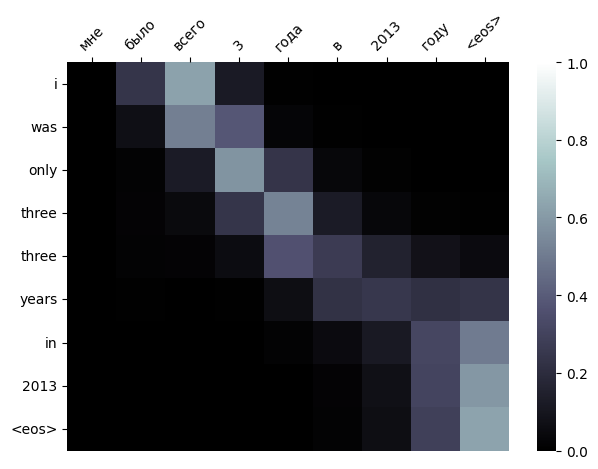

In [ ]:
attn_plot = plot_attention(attn_frame)
attn_plot.tight_layout()
attn_plot.show()

In [ ]:
translation, attn_frame = get_translation_and_attention_frame("том целый день нe выключает телевизор", model, rus_tokenizer, en_vocab, ru_vocab)

In [ ]:
translation

['tom', 'is', 'his', 'tv', 'all', 'all', 'day', '<eos>']

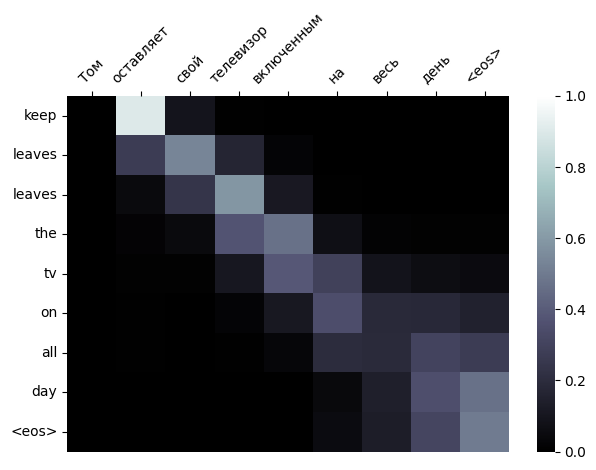

In [ ]:
attn_plot = plot_attention(attn_frame)
attn_plot.tight_layout()
attn_plot.show()